# TRAINING

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from sklearn.model_selection import KFold, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
df = pd.read_csv('train.csv', sep=',', index_col=['id'])

va = {'> 2 Years': 2, '1-2 Year': 1, '< 1 Year': 0}
gen = {'Male' : 0, 'Female' : 1}
vg = {'Yes' : 1, 'No' : 0}
df['Vehicle_Age'] = df['Vehicle_Age'].map(va)
df['Gender'] = df['Gender'].map(gen)
df['Vehicle_Damage'] = df['Vehicle_Damage'].map(vg)

num_feat = ['Age', 'Vintage']

cat_feat = [
    'Gender', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage',
    'Driving_License', 'Policy_Sales_Channel', 'Region_Code'
]

In [3]:
scl = MinMaxScaler()

num_scl = pd.DataFrame(scl.fit_transform(df[num_feat]))
num_scl.index = df[num_feat].index
num_scl.columns = df[num_feat].columns
X_ = pd.concat([num_scl, df[cat_feat]], axis=1)
X_.head()

,Age,Vintage,Gender,Previously_Insured,Vehicle_Age,Vehicle_Damage,Driving_License,Policy_Sales_Channel,Region_Code
id,,,,,,,,,
1,0.369231,0.716263,0,0,2,1,1,26.0,28.0
2,0.861538,0.598616,0,0,1,0,1,26.0,3.0
3,0.415385,0.058824,0,0,2,1,1,26.0,28.0
4,0.015385,0.667820,0,1,0,0,1,152.0,11.0
5,0.138462,0.100346,1,1,0,0,1,152.0,41.0


In [4]:
y = df.Response
X_.shape, y.shape

((381109, 9), (381109,))

In [5]:
grid_param = {
    'num_leaves': [60, 70, 80],
    'min_child_weight': [0.1, 0.5, 1, 1.5, 2],
    'feature_fraction': [0.1, 0.5, 1, 1.5, 2],
    'bagging_fraction': [0.1, 0.5, 1, 1.5, 2],
    'max_depth': [6, 7, 8],
    'learning_rate': [0.9, 0.1, 0.12, 0.15],
    'reg_alpha': [0.5, 0.9, 1.2, 1.8],
    'reg_lambda': [0.5, 0.9, 1.2, 1.8,],
    'num_iterations': [90, 100, 110]
}

model = lgb.LGBMClassifier(random_state=22)

grid_fold = KFold(n_splits=5, shuffle=True, random_state=12)

grid_search = RandomizedSearchCV(model,
                                 param_distributions=grid_param,
                                 scoring='roc_auc',
                                 cv=grid_fold,
                                 n_jobs=-1,
                                 verbose=1,
                                 random_state=112)

grid_result = grid_search.fit(X_, y)
print(grid_result.best_score_, grid_result.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   35.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   36.9s finished
c:\users\adil_\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
0.85760672823576 {'reg_lambda': 1.8, 'reg_alpha': 0.9, 'num_leaves': 80, 'num_iterations': 90, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.12, 'feature_fraction': 0.5, 'bagging_fraction': 0.5}


In [31]:
params = {
    'reg_lambda': 1.8,
    'reg_alpha': 0.9,
    'num_leaves': 80,
    'min_child_weight': 1,
    'max_depth': 6,
    'learning_rate': 0.12,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'objective': 'binary',
    "boosting_type": "gbdt",
    "bagging_seed": 23,
    "metric": 'auc',
    "verbosity": -1
}

In [34]:
n_folds = 5
fold = KFold()
splits = fold.split(X_, y)
columns = X_.columns
oof = np.zeros(X_.shape[0])
score = 0
y_oof = np.zeros(X_.shape[0])
feature_importances = pd.DataFrame()
feature_importances['feature'] = columns

In [35]:
for fold_n, (train_index, valid_index) in enumerate(splits):
    X_train, X_valid = X_[columns].iloc[train_index], X_[columns].iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    dtrain = lgb.Dataset(X_train, label = y_train)
    dvalid = lgb.Dataset(X_valid, label = y_valid)
    
    clf = lgb.train(params, dtrain, 70, valid_sets=[dtrain, dvalid], 
                    verbose_eval=100)
    
    feature_importances[f'fold_{fold_n + 1}'] = clf.feature_importance()
    
    y_pred_valid = clf.predict(X_valid)
    y_oof[valid_index] = y_pred_valid
    print(f"Fold {fold_n + 1} | AUC: {roc_auc_score(y_valid, y_pred_valid)}")
    score += roc_auc_score(y_valid, y_pred_valid) / n_folds
    
print(f"\nMean AUC = {score}")
print(f"Out of folds AUC = {roc_auc_score(y, y_oof)}")

Fold 1 | AUC: 0.8589221359060801
Fold 2 | AUC: 0.8581468130792711
Fold 3 | AUC: 0.8567409426959761
Fold 4 | AUC: 0.8575129093520134
Fold 5 | AUC: 0.8561340989667129

Mean AUC = 0.8574913800000108
Out of folds AUC = 0.8574642889162474


Text(0.5, 1.0, 'TOP feature importance over 5 folds average')

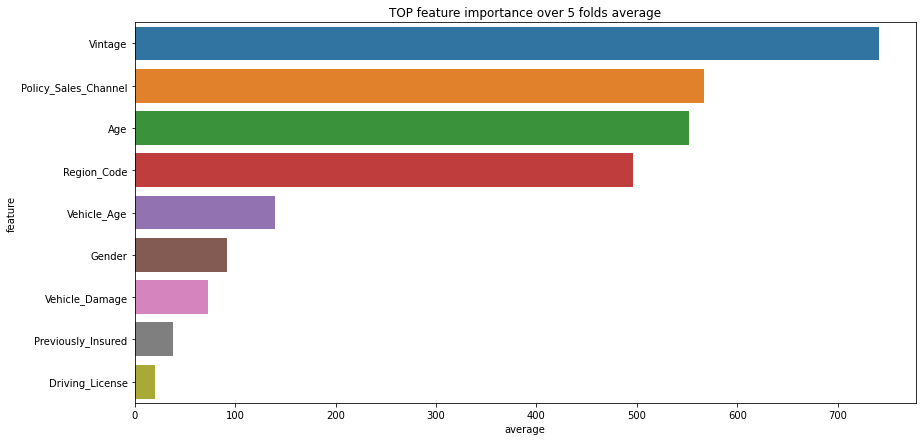

In [16]:
feature_importances['average'] = feature_importances[[
    f'fold_{fold_n + 1}' for fold_n in range(fold.n_splits)
]].mean(axis=1)

plt.figure(figsize=(14, 7))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(9), x='average', y='feature');
plt.title('TOP feature importance over {} folds average'.format(fold.n_splits))

# TESTING

In [17]:
test_data = pd.read_csv('test.csv', sep=',', index_col=['id'])
test_data.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
id,,,,,,,,,,
381110,Male,25,1,11.0,1,< 1 Year,No,35786.0,152.0,53
381111,Male,40,1,28.0,0,1-2 Year,Yes,33762.0,7.0,111
381112,Male,47,1,28.0,0,1-2 Year,Yes,40050.0,124.0,199
381113,Male,24,1,27.0,1,< 1 Year,Yes,37356.0,152.0,187
381114,Male,27,1,28.0,1,< 1 Year,No,59097.0,152.0,297


In [18]:
test_data['Vehicle_Age'] = test_data['Vehicle_Age'].map(va)
test_data['Gender'] = test_data['Gender'].map(gen)
test_data['Vehicle_Damage'] = test_data['Vehicle_Damage'].map(vg)
test_data.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
id,,,,,,,,,,
381110,0,25,1,11.0,1,0,0,35786.0,152.0,53
381111,0,40,1,28.0,0,1,1,33762.0,7.0,111
381112,0,47,1,28.0,0,1,1,40050.0,124.0,199
381113,0,24,1,27.0,1,0,1,37356.0,152.0,187
381114,0,27,1,28.0,1,0,0,59097.0,152.0,297


In [19]:
num_scl = pd.DataFrame(scl.fit_transform(test_data[num_feat]))
num_scl.index = test_data[num_feat].index
num_scl.columns = test_data[num_feat].columns
test = pd.concat([num_scl, test_data[cat_feat]], axis=1)
test.head()

,Age,Vintage,Gender,Previously_Insured,Vehicle_Age,Vehicle_Damage,Driving_License,Policy_Sales_Channel,Region_Code
id,,,,,,,,,
381110,0.076923,0.148789,0,1,0,0,1,152.0,11.0
381111,0.307692,0.349481,0,0,1,1,1,7.0,28.0
381112,0.415385,0.653979,0,0,1,1,1,124.0,28.0
381113,0.061538,0.612457,0,1,0,1,1,152.0,27.0
381114,0.107692,0.993080,0,1,0,0,1,152.0,28.0


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_,
                                                    y,
                                                    train_size=0.8,
                                                    random_state=112)

In [21]:
best_model = lgb.LGBMClassifier(reg_lambda=1.8,
                                reg_alpha=0.9,
                                num_leaves=80,
                                min_child_weight=1,
                                max_depth=6,
                                learning_rate=0.12,
                                feature_fraction=0.5,
                                bagging_fraction=0.5,
                                objective='binary',
                                boosting_type='gbdt',
                                bagging_seed=23,
                                metric='auc',
                                verbosity=-1,
                                n_estimators = 70)

best_model.fit(X_train, y_train)
best_model.predict_proba(X_test)

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5


array([[9.98968419e-01, 1.03158112e-03],
       [8.19369090e-01, 1.80630910e-01],
       [9.07874927e-01, 9.21250729e-02],
       ...,
       [9.98477503e-01, 1.52249713e-03],
       [9.99005979e-01, 9.94020712e-04],
       [6.82638762e-01, 3.17361238e-01]])

In [22]:
Preds = [predClass[1] for predClass in best_model.predict_proba(test.values)]

In [23]:
submission = pd.DataFrame({'id': test.index, 'Response': Preds})
submission.to_csv('healthcare.csv', index = False)
submission.head()

,id,Response
0,381110,0.001251
1,381111,0.296446
2,381112,0.306443
3,381113,0.008405
4,381114,0.000716
